In [1]:
from PIL import Image
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
import cv2

In [24]:
def show_images(images, size=(16, 8), mode='grayscale', dpi=150, image_type=None, grid=None, title=None, fig_suptitle=None): 
        if not isinstance(images, tuple) and not isinstance(images, list):
            images = [images]
            title = [title]
            grid = (1, 1)
        if isinstance(mode, tuple) or isinstance(mode, list):
            change_mode = True
        else:
            current_mode = mode
            change_mode = False
        
        if isinstance(image_type, tuple) or isinstance(image_type, list):
            change_mode_type = True
        else:
            current_mode_type = image_type
            change_mode_type = False
        
        if not grid:
            grid = []
            grid.append(math.ceil(len(images) / 2))
            grid.append(1)
            
        fig=plt.figure(figsize=size, dpi=dpi)
        for i, img in enumerate(images):
            fig.add_subplot(grid[0], grid[1], i+1)

            if change_mode:
                current_mode = mode[i]
            if change_mode_type:
                current_mode_type = image_type[i]

            if current_mode=='grayscale':
                if current_mode_type=='spectrum':
                    plt.imshow(np.abs(img)**(0.1), cmap='gray')
                else:
                    plt.imshow(img, cmap='gray')
            else:
                if current_mode_type=='spectrum':
                    plt.imshow(np.abs(img)**(0.1))
                else:
                    plt.imshow(img)
                    
            if title and title[i] is not None:
                plt.title(title[i], fontsize=18)
            plt.axis('off')
        if fig_suptitle:
            fig.suptitle(fig_suptitle, fontsize=25)
        plt.show()

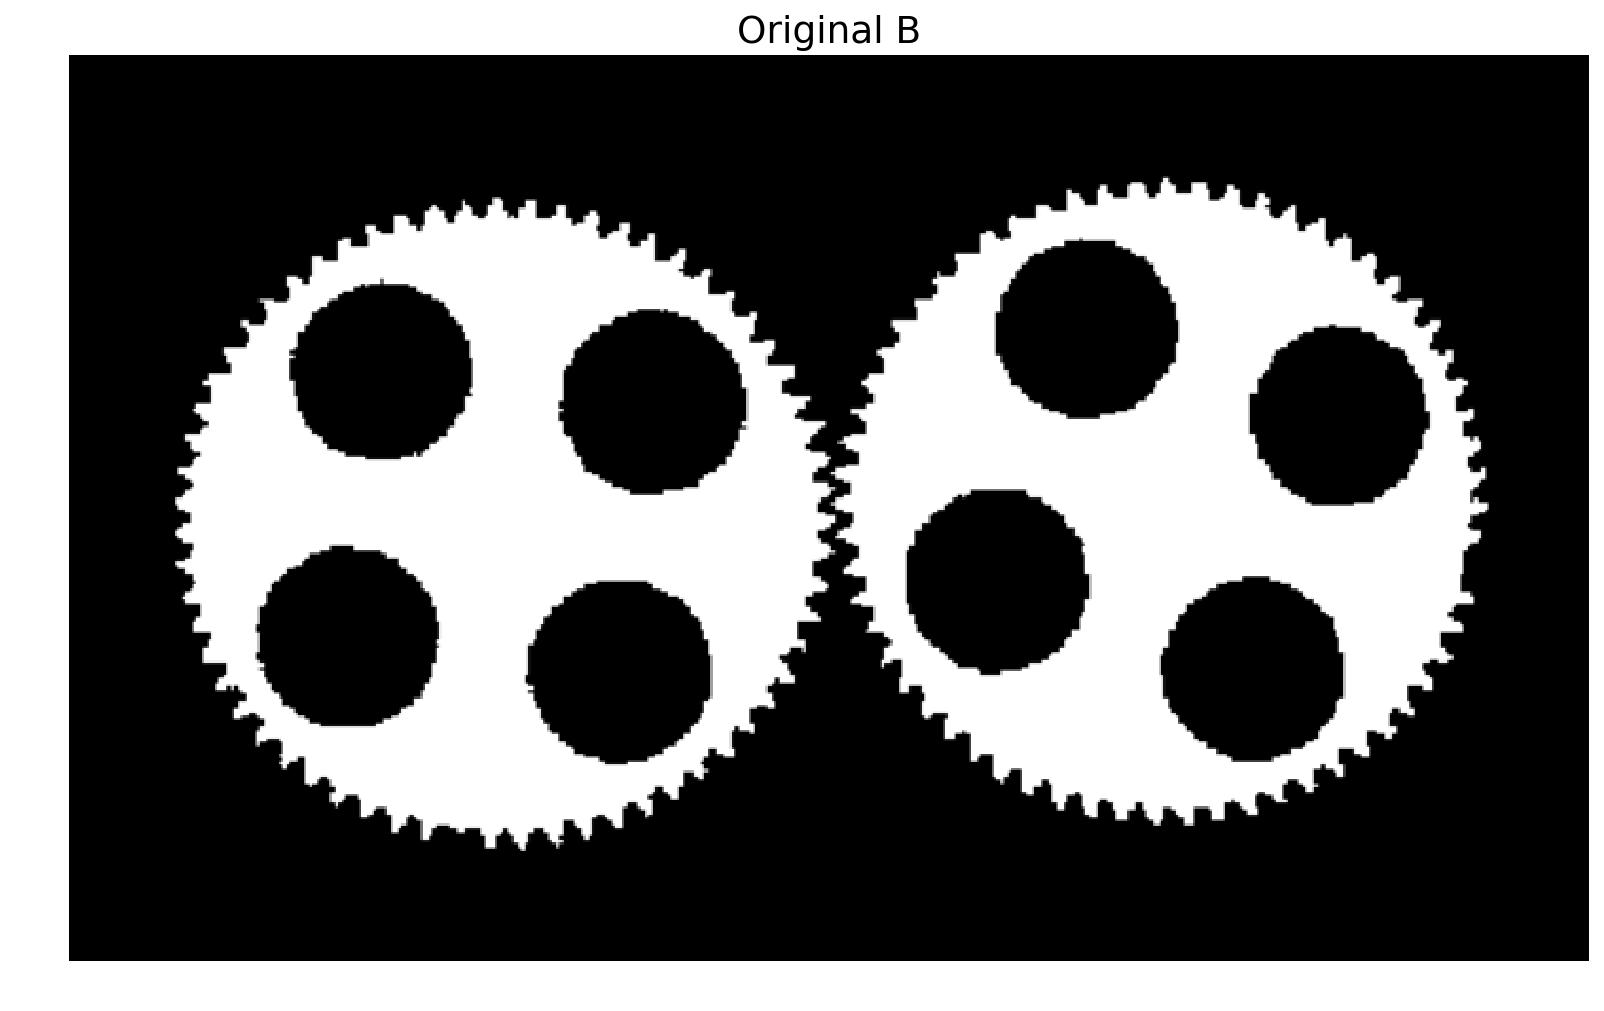

In [25]:
img_path = './gears.png'
img = cv2.imread(img_path, 0)
show_images(img, mode='grayscale', title='Original B')

In [26]:
def get_hole_rings(r):
    d = r * 2 + 1
    x, y = np.indices((d, d))
    dist = np.hypot(r - x, r - y)
    ring_mask = np.abs(dist - r) < 0.5
    return ring_mask.astype(np.uint8)

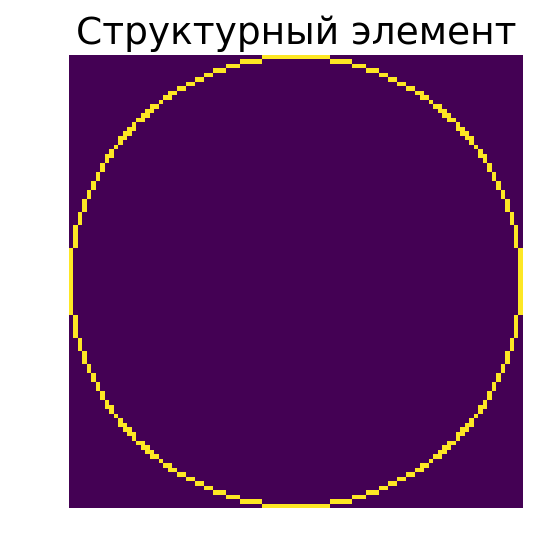

In [27]:
hole_rings = get_hole_rings(50)
show_images(hole_rings, mode='rgb', title=("Структурный элемент"), size = (4,4))


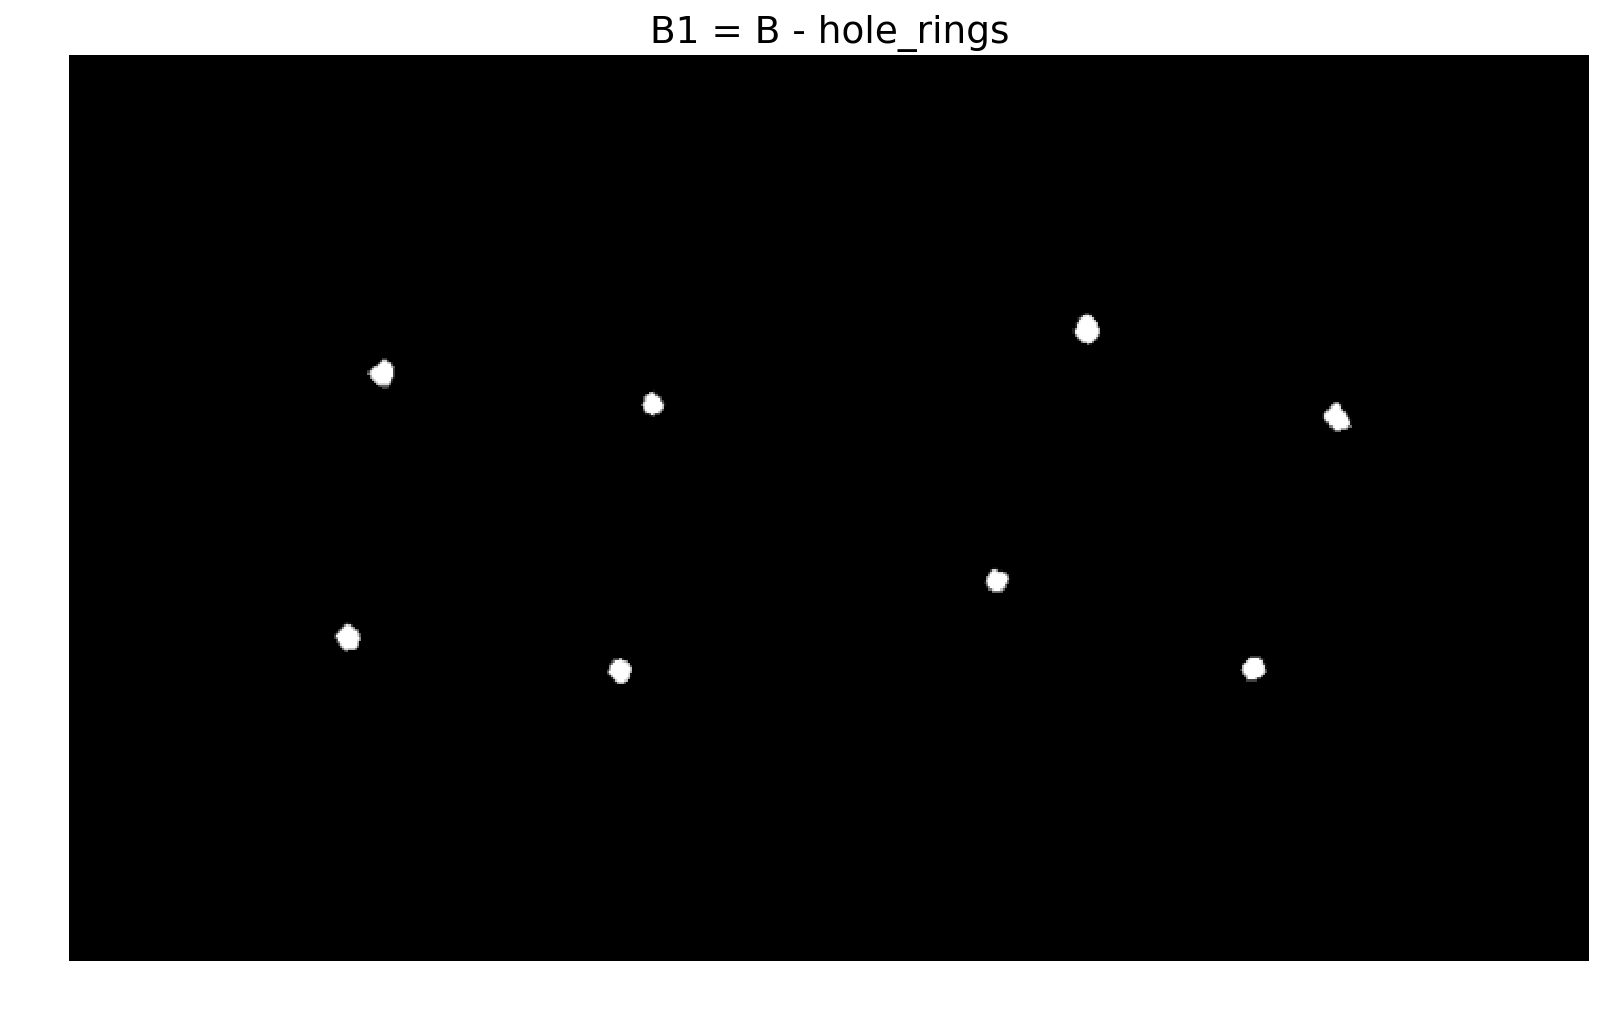

In [28]:
b_hole_rings = cv2.erode(img, hole_rings)
show_images(b_hole_rings, title=("B1 = B - hole_rings"))

In [29]:
hole_mask = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (85,85))
b_hole_mask = cv2.dilate(b_hole_rings, hole_mask)

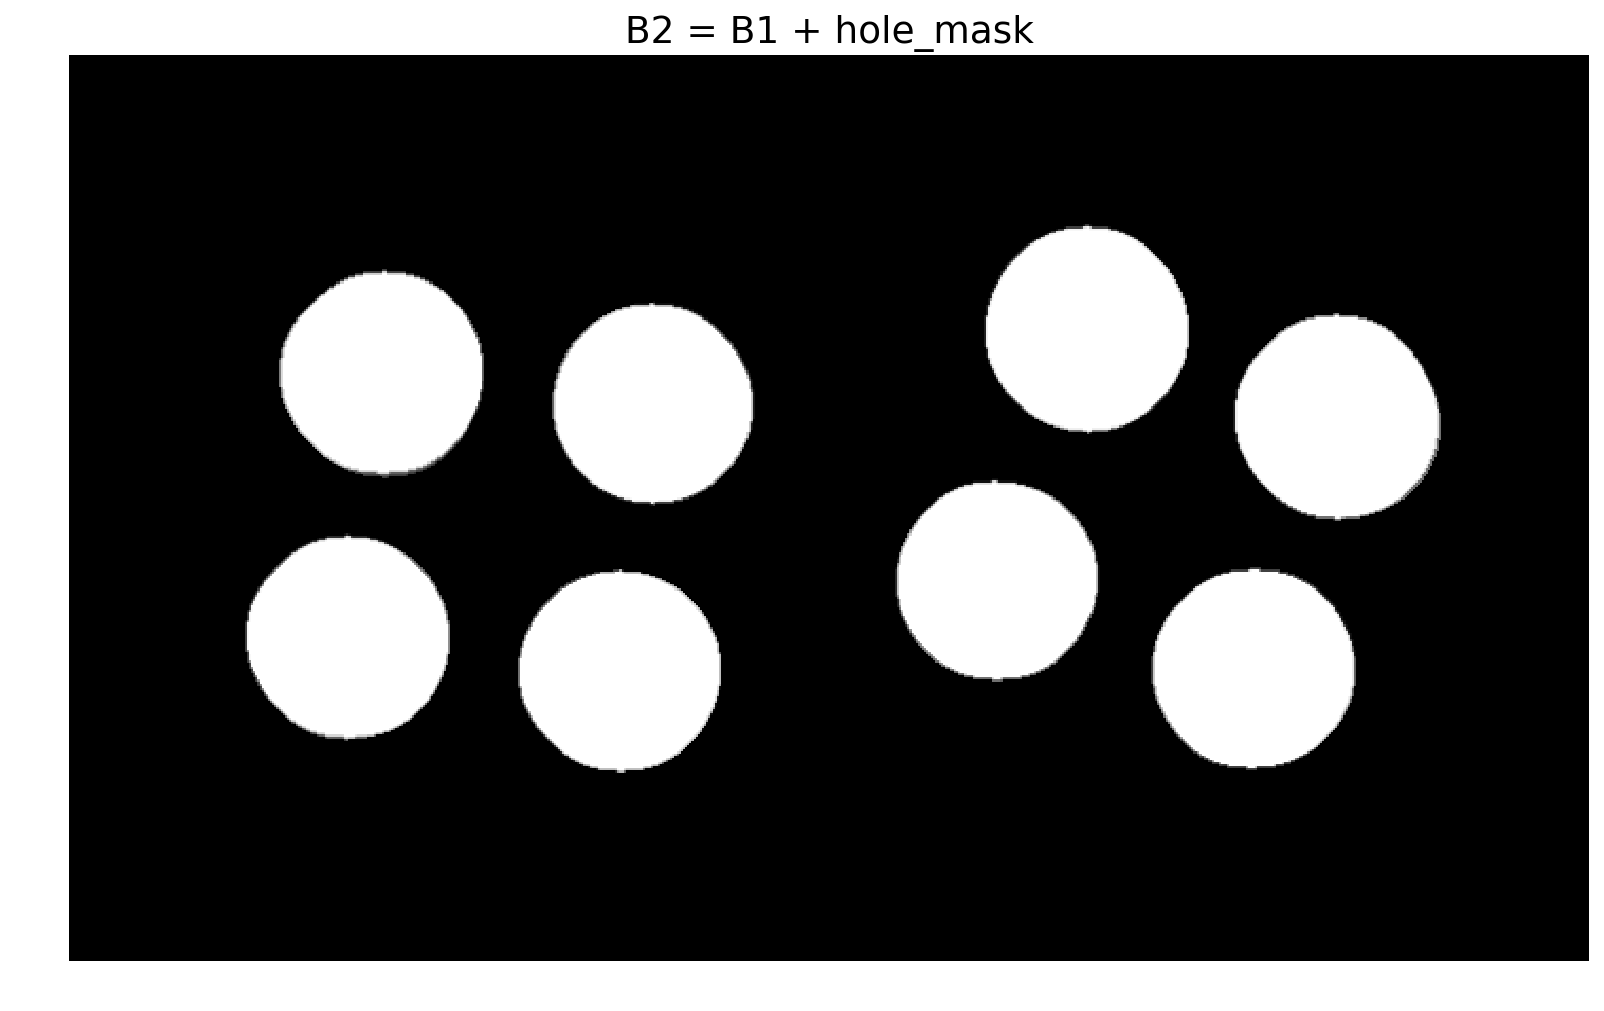

In [30]:
show_images(b_hole_mask, title=("B2 = B1 + hole_mask"))

In [31]:
bitwise_image = cv2.bitwise_or(img, b_hole_mask)

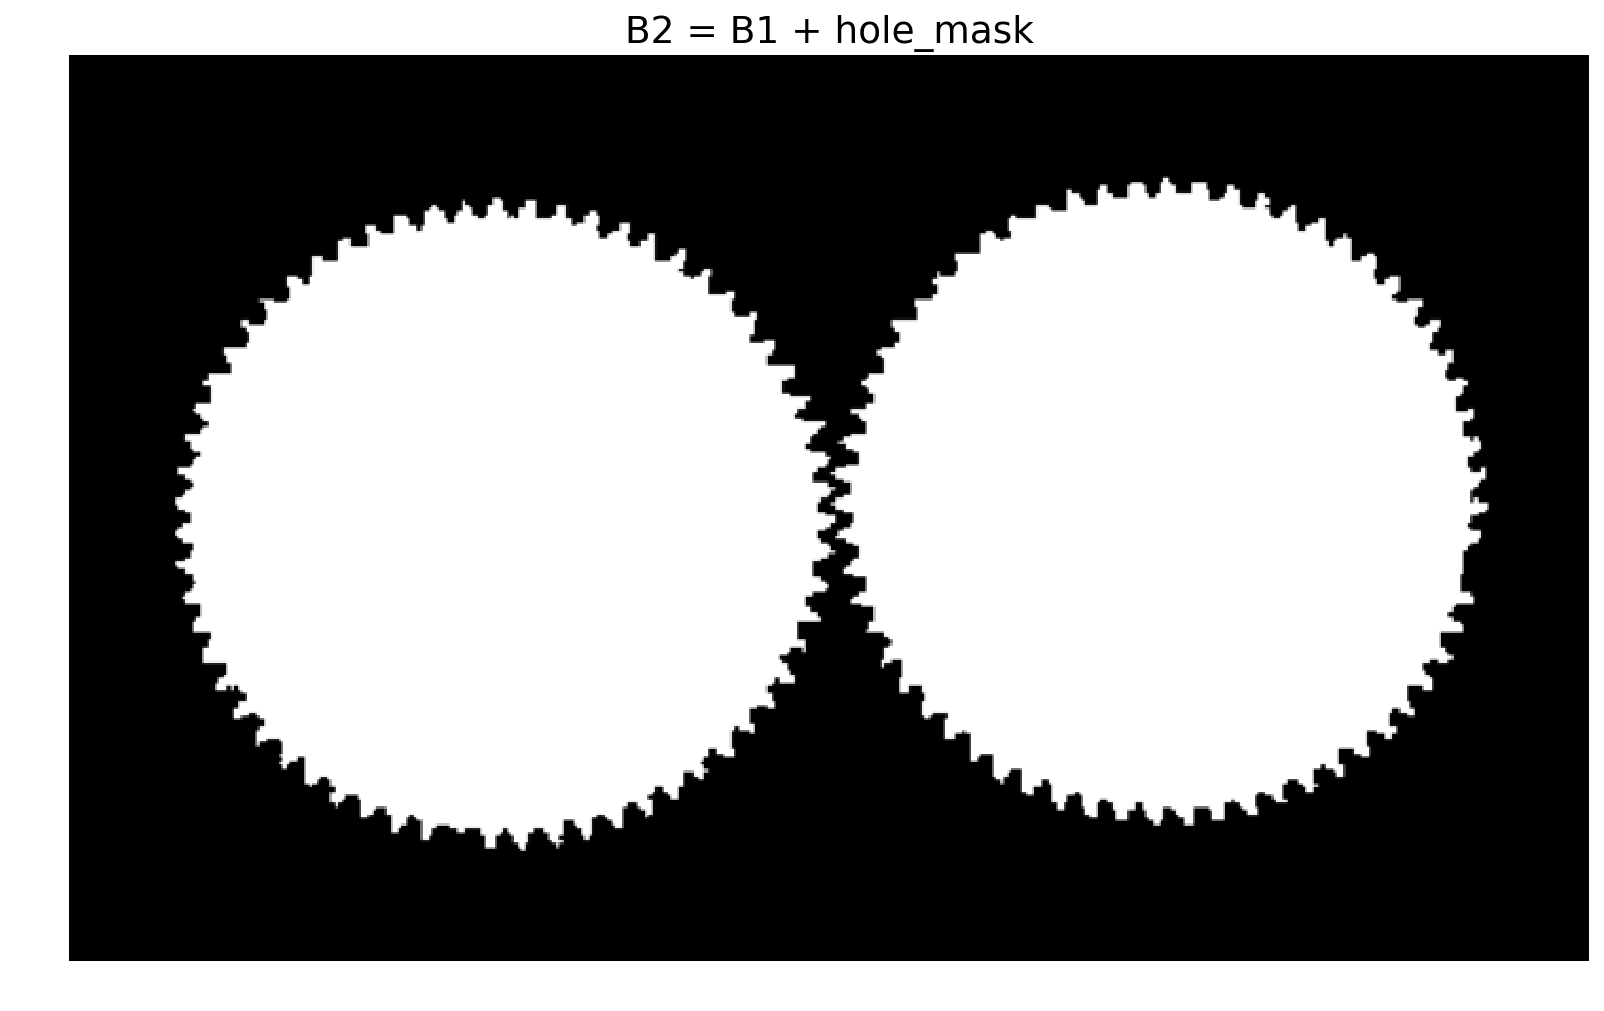

In [32]:
show_images(bitwise_image, title=("B2 = B1 + hole_mask"))

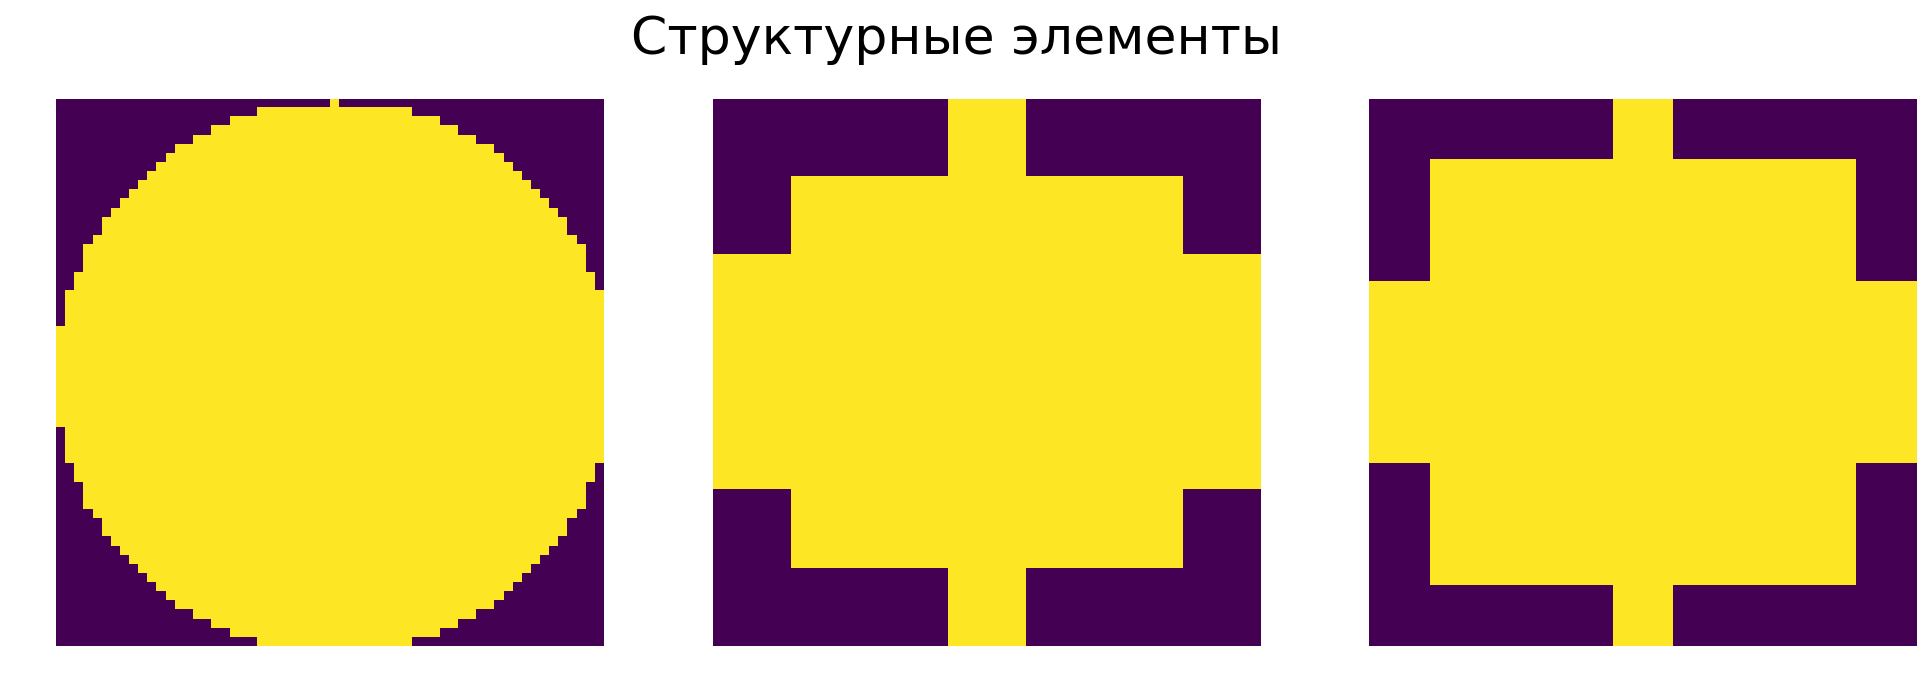

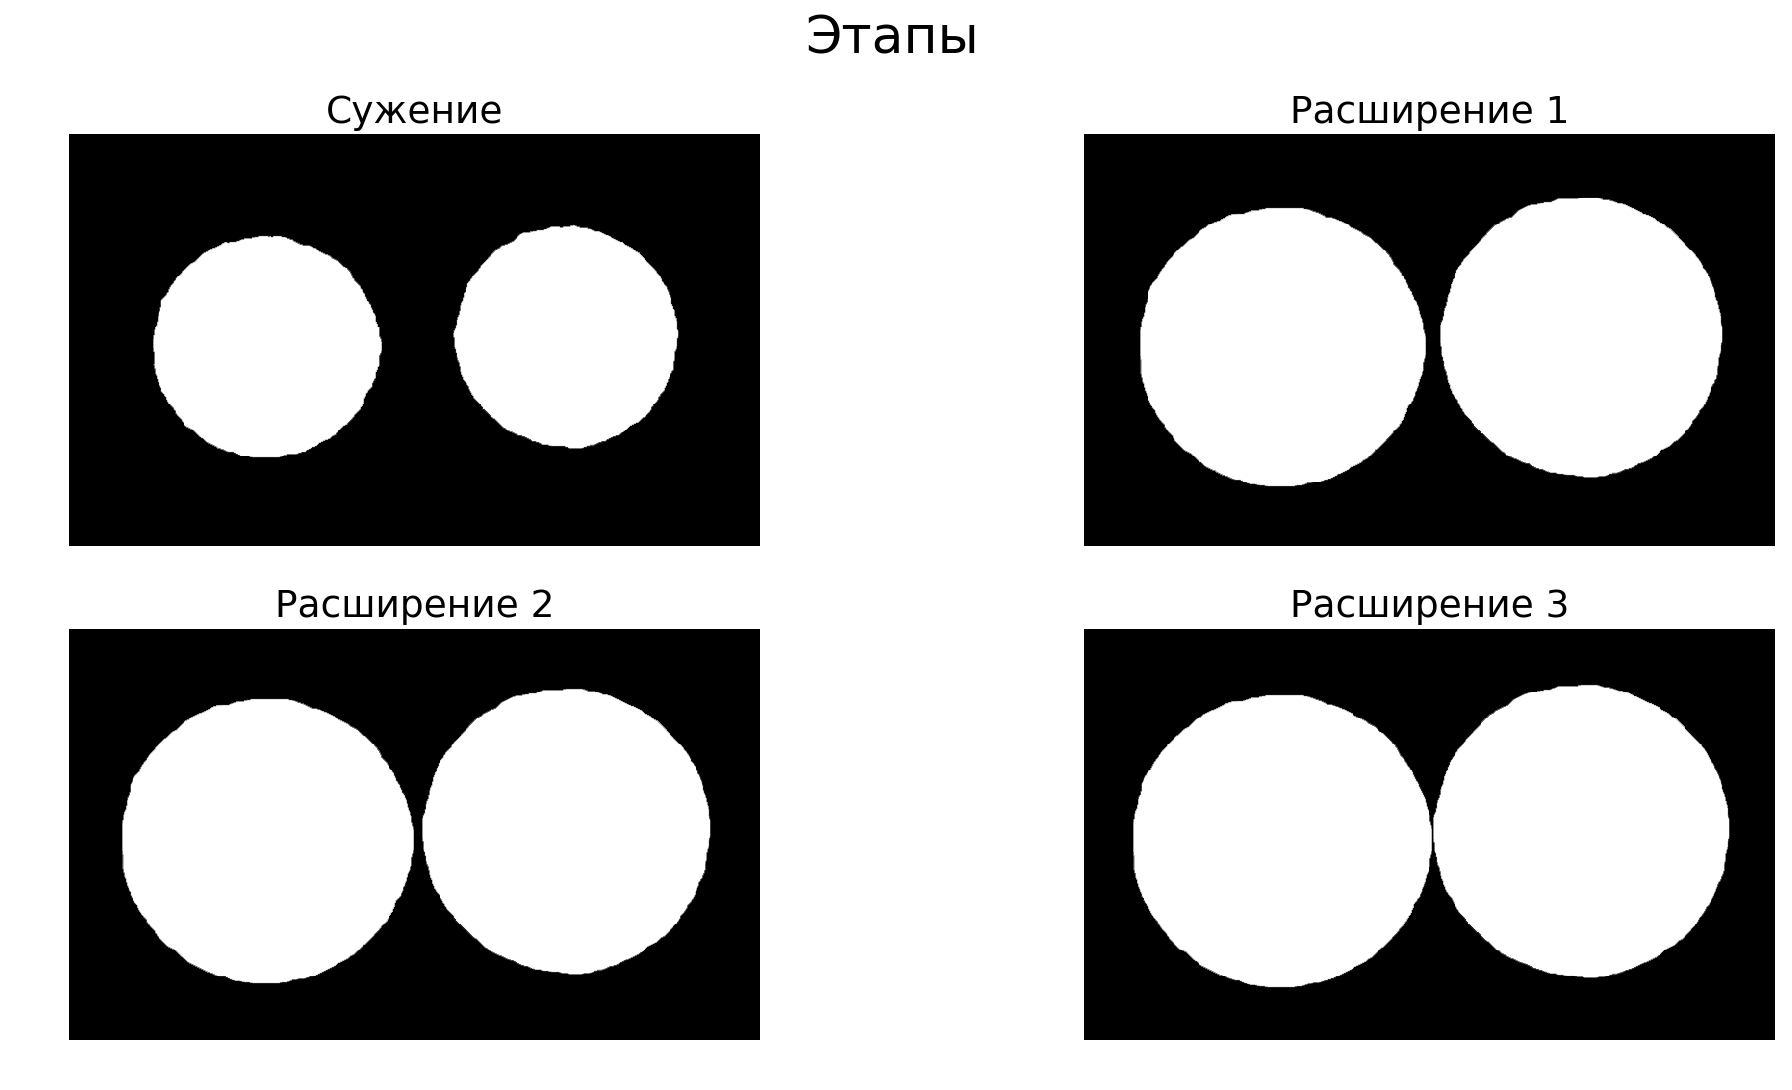

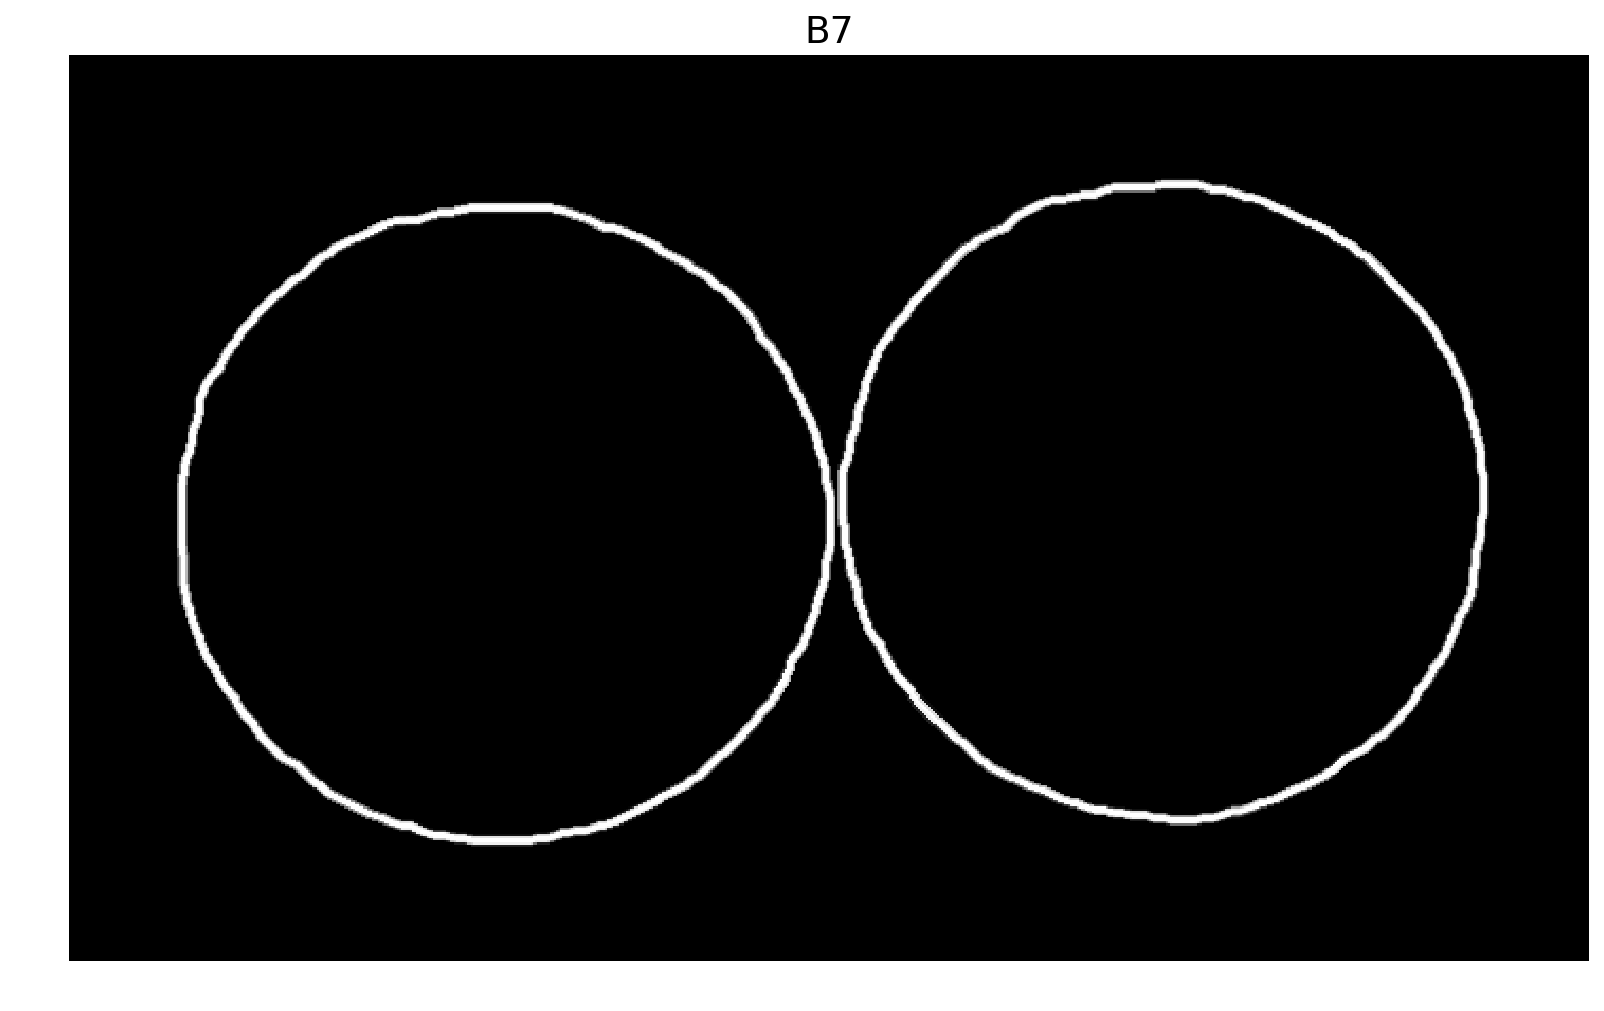

In [33]:
def find_ring(bitwise_image):
    gear_body = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (60, 60))

    body_image = cv2.erode(bitwise_image, gear_body)
    body_image_1 = cv2.dilate(body_image, gear_body)

    ring_spacer = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    body_image_2 = cv2.dilate(body_image_1, ring_spacer)

    ring_spacer_3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    body_image_3 = cv2.dilate(body_image_2, ring_spacer_3)

    rings_image = cv2.subtract(body_image_3, body_image_2)
    
    show_images([gear_body, ring_spacer, ring_spacer_3], 
                size = (16,5),
                grid=(1,3),
                mode='rgb', 
                fig_suptitle="Структурные элементы")
    show_images([body_image, 
                 body_image_1, 
                 body_image_2,
                 body_image_3], 
                 fig_suptitle = "Этапы",
                size=(16,8),
                grid = (2,2),
                 title=("Сужение", 
                        "Расширение 1",
                        "Расширение 2", 
                        "Расширение 3")
                )
    show_images(rings_image, title=("B7"))
    return rings_image

rings_image = find_ring(bitwise_image)    

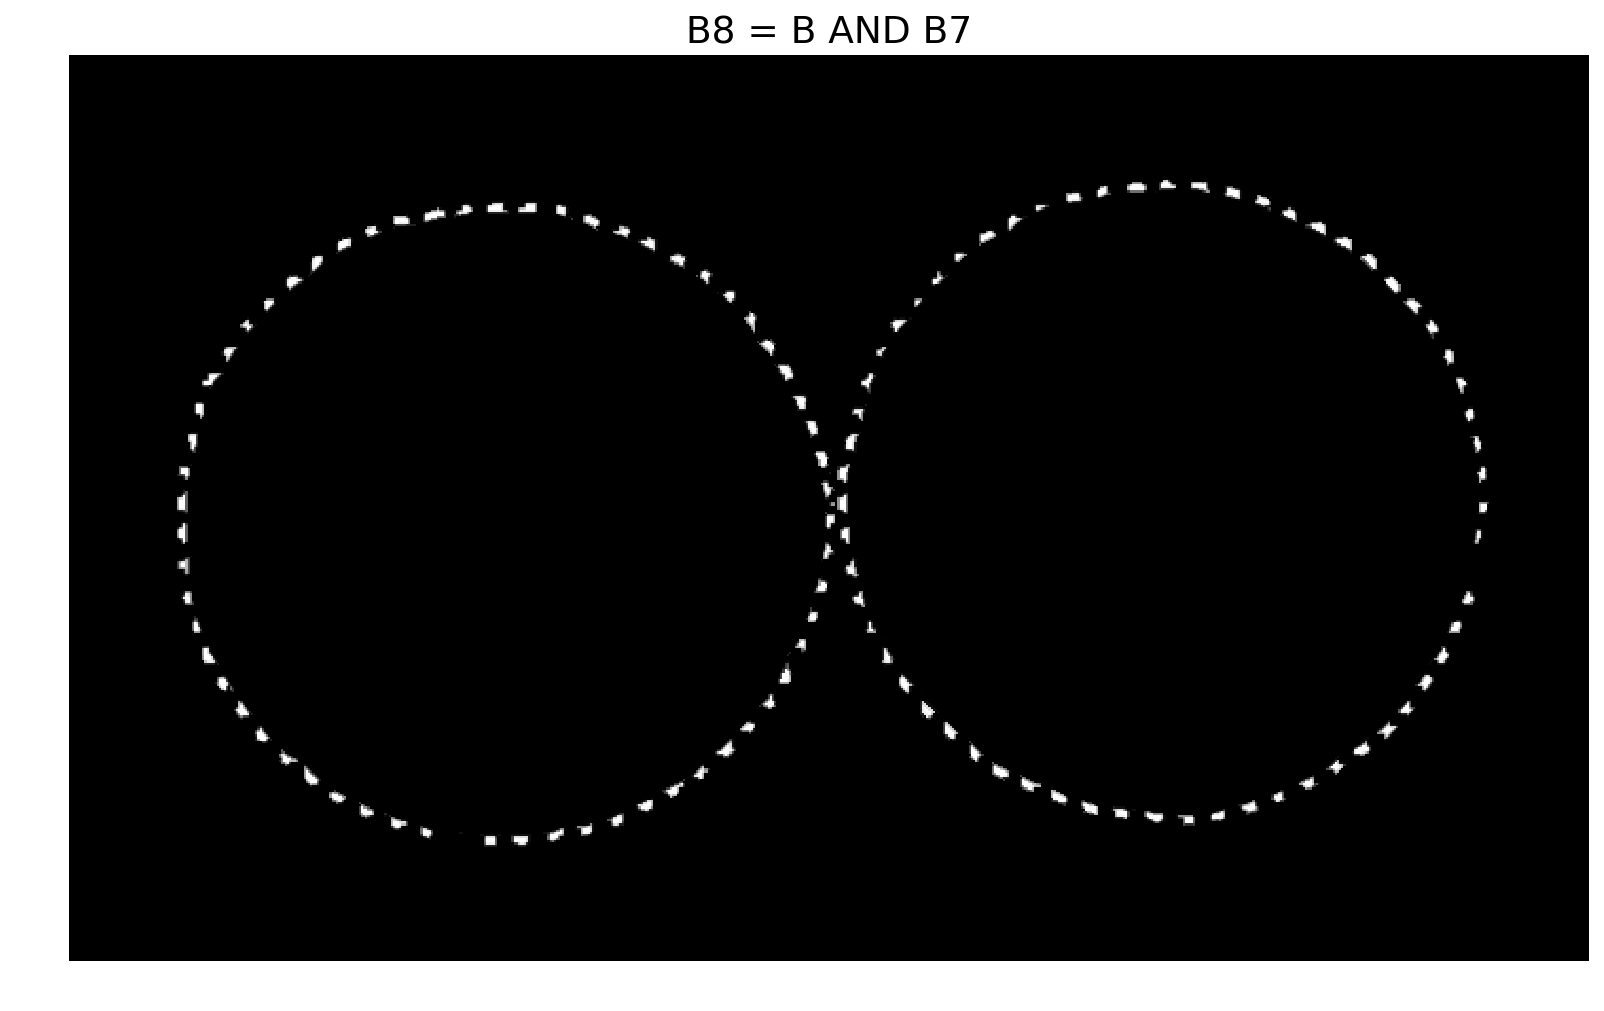

In [36]:
dotted_rings = cv2.bitwise_and(bitwise_image, rings_image)
show_images(dotted_rings, title=("B8 = B AND B7"))

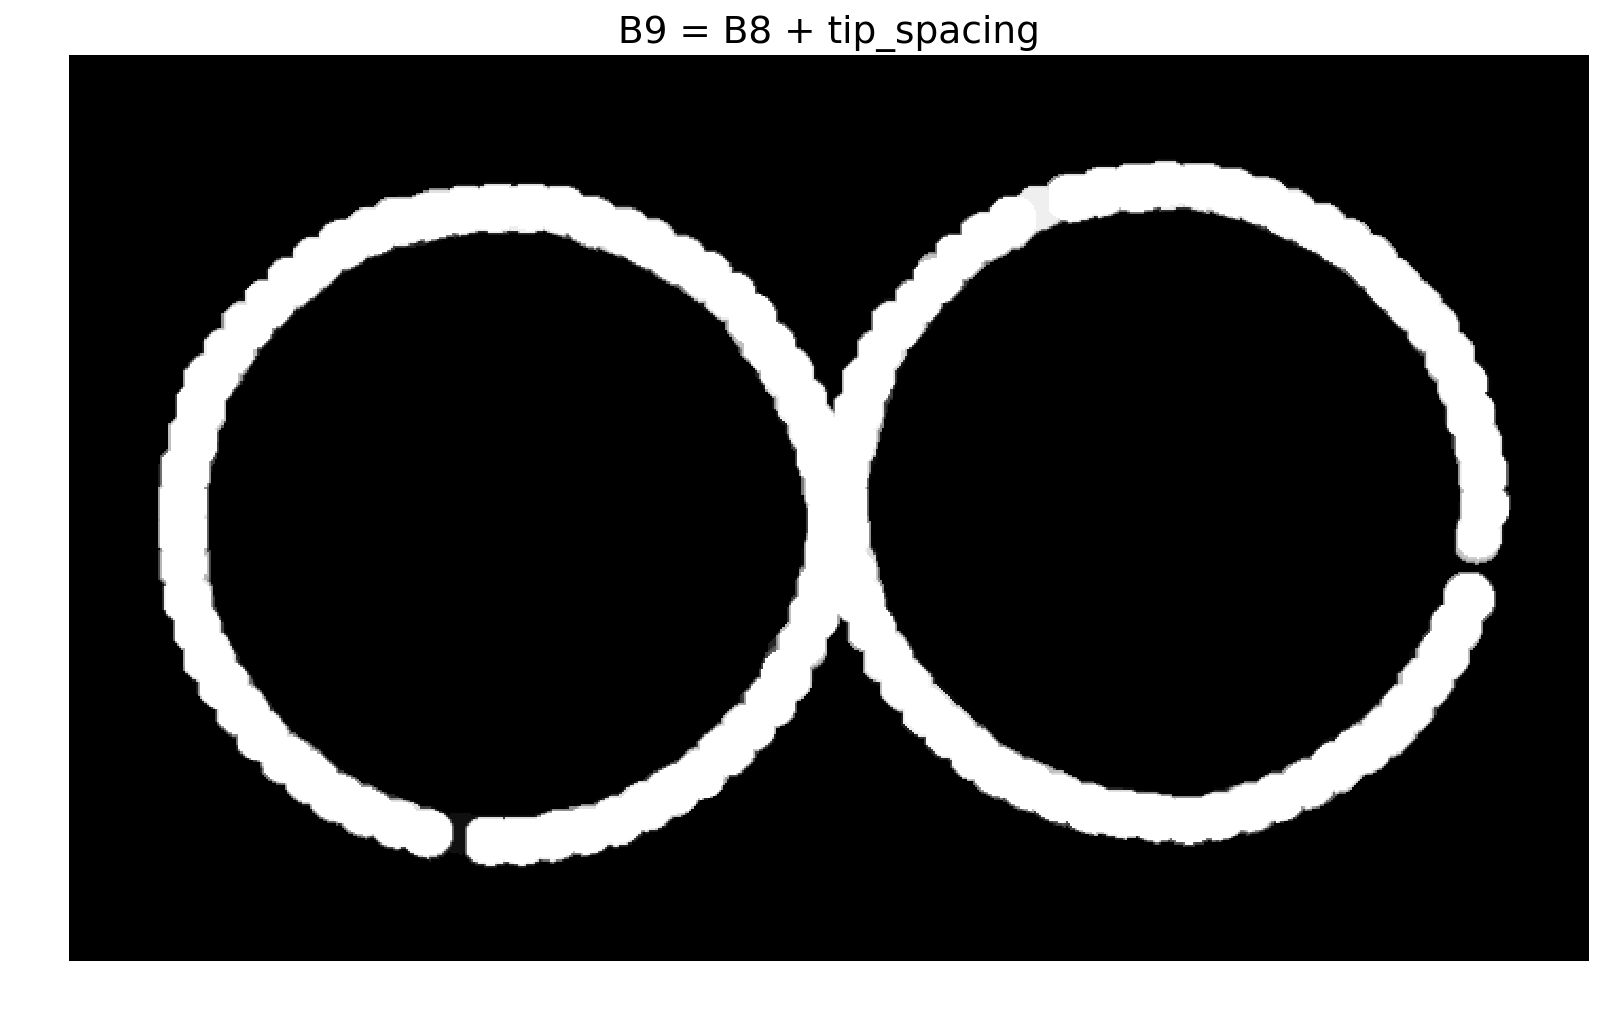

In [38]:
spaced_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))
tip_spacing = cv2.dilate(dotted_rings, spaced_ellipse)
show_images(spaced_rings, title=("B9 = B8 + tip_spacing"))

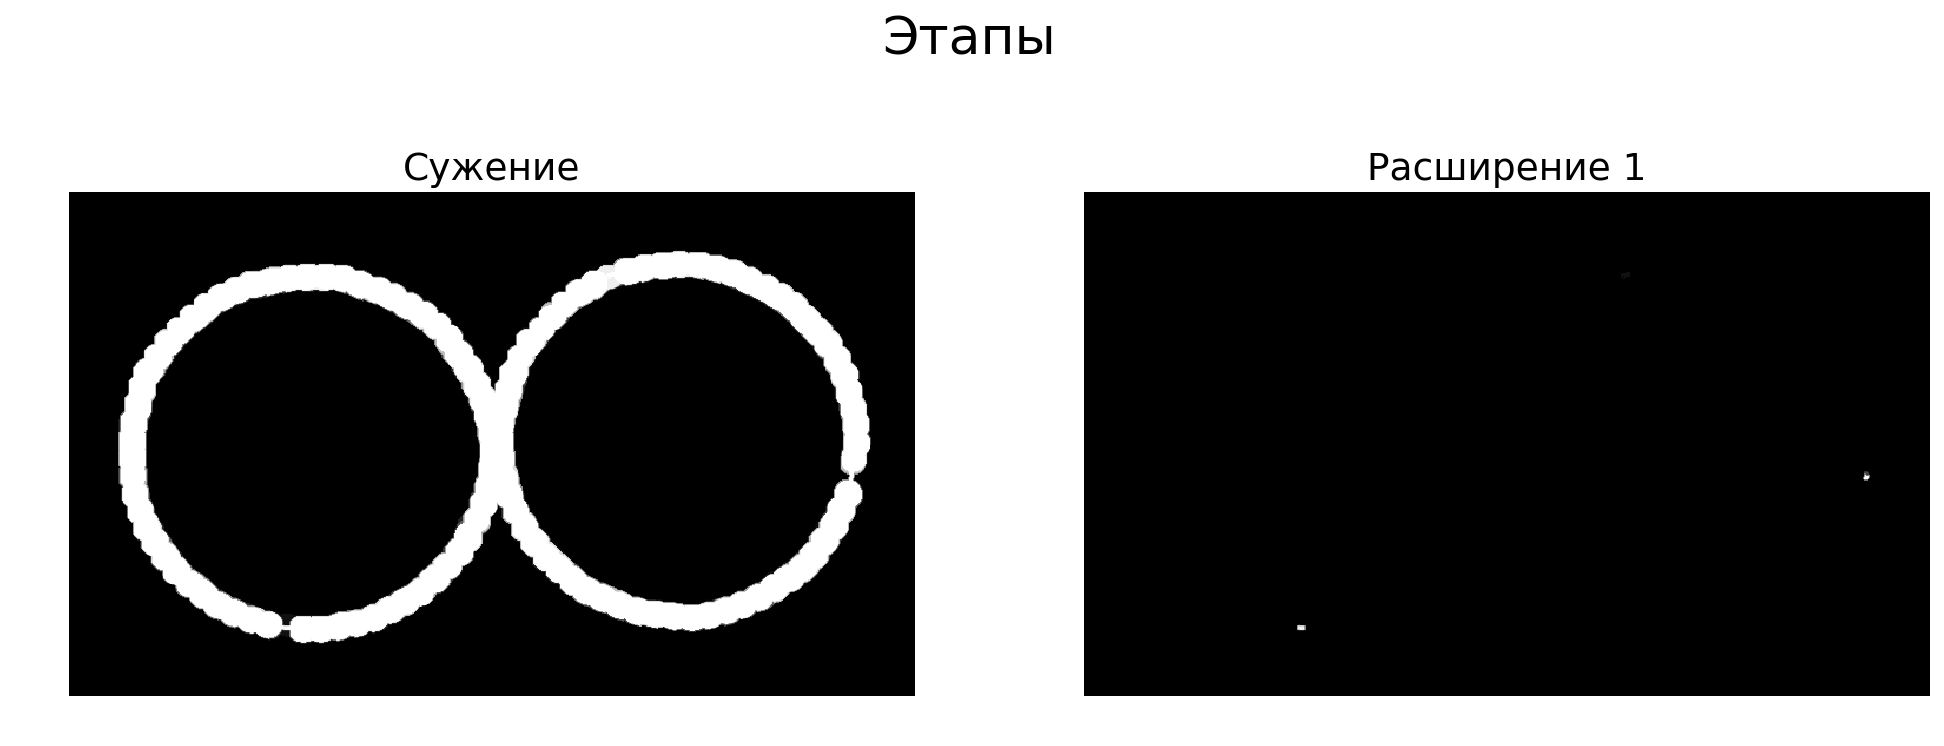

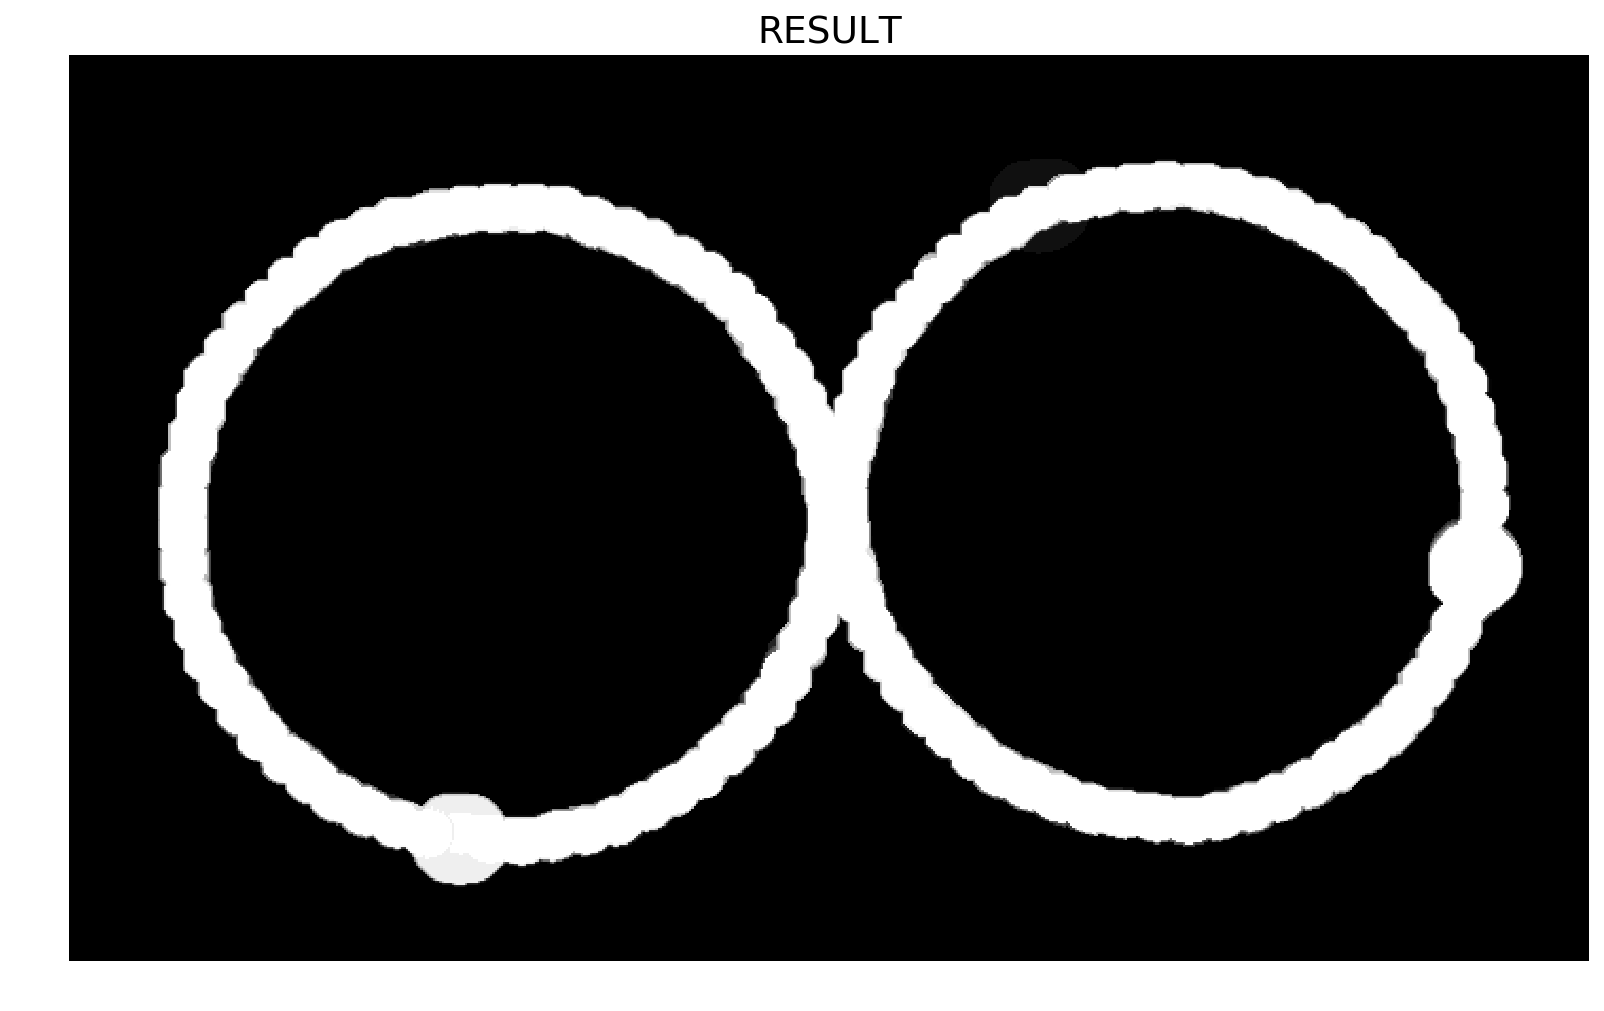

In [50]:
def find_and_fill_holes(spaced_rings, rings_image):
    defect_cue = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (40, 40))
    # Объединим кольцо с отверстием дефекта с тонким кольцом без отверстий
    dotted_rings = cv2.bitwise_or(spaced_rings,rings_image)

    # Вычтем из получившегося изображения кольцо с отверстием дефекта и получим дефектные точки
    dot_img = dotted_rings - spaced_rings

    # Расширяем и объединяем дефектные точки с кольцом
    dots = cv2.dilate(dot_img,defect_cue)    
    result = cv2.bitwise_or(dots, spaced_rings)
    
    show_images([dotted_rings, 
                 dot_img], 
                 fig_suptitle = "Этапы",
                size=(16,6),
                grid = (1,2),
                 title=("Сужение", 
                        "Расширение 1",
                        "Расширение 2", 
                        "Расширение 3")
                )
    show_images(result, title = "RESULT")
find_and_fill_holes(spaced_rings, rings_image)